# 4.2.2 Dependence on the Node Degree

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from sensible_raw.loaders import loader
from world_viewer.cns_world import CNSWorld
from world_viewer.glasses import Glasses
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.colors import LogNorm
from sklearn.utils import shuffle


In [2]:
#load data
cns = CNSWorld()
cns.load_world(opinions = ['fitness'], read_cached = False, stop=False, write_pickle = False, continous_op=False)
cns_glasses = Glasses(cns)

# load exposure
exposure = pd.read_pickle("tmp/fitness_exposure_tx7.pkl")#.set_index(['node_id','time'])

# alternative: recalculate exposure value
# exposure = cns_glasses.calc_exposure("expo_frac", "op_fitness", exposure_time = 7)

Process opinion data for variable: fitness


In [3]:
# set analysis params
analysis = 'expo_frac'
opinion_type = "op_fitness"
binning = True
n_bins = 10
save_plots = True
show_plot = True

In [21]:
# filter by degre
degree = exposure.groupby("node_id").n_nbs.mean().to_frame("avg").reset_index()
exposure = exposure.loc[degree.loc[degree.avg >= 4,"node_id"]]
exposure = exposure[exposure.n_nbs_mean > 1/7]

# column "exposure" equals relative exposure
# column "n_influencer_summed" equals absolute exposure
# use absolute exposure for further calculations
exposure.rename(columns={"exposure":"exposure_old", "n_influencer_summed":"exposure"},inplace=True)

# select time period: spring
start = "2014-02-01"
end = "2014-04-30"
exposure.reset_index(inplace=True)
exposure = exposure.loc[(exposure.time >= pd.to_datetime(start)) & (exposure.time <= pd.to_datetime(end))]
exposure.set_index(['node_id','time'],inplace=True)

<IPython.core.display.Javascript object>


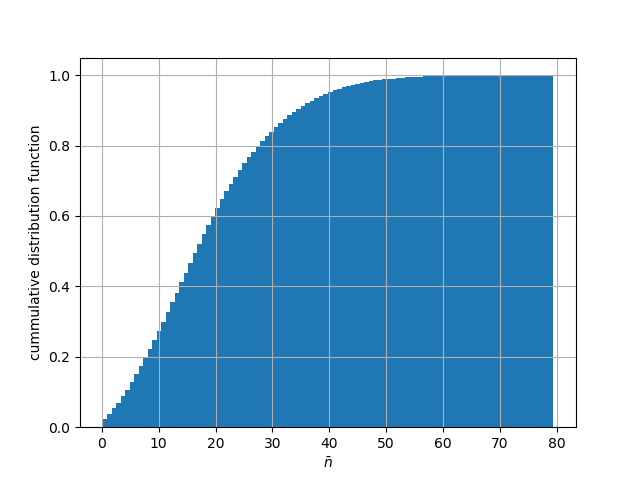

In [29]:
# plot fig. 6.2

plt.subplots()
exposure.n_nbs_mean.hist( cumulative=True,bins=100, density=True)
plt.xlabel(r"$\bar n$")
plt.ylabel("cummulative distribution function")
plt.savefig("tmp/final/n_bar_cdf.pdf")

In [5]:
# calculate if nodes changed trait after experiencing a certain exposure
# save value as column "op_change" (bool)
data, expo_agg = cns_glasses.opinion_change_per_exposure(exposure, opinion_type, opinion_change_time = 1)

INFO: Calc op-change


<IPython.core.display.Javascript object>


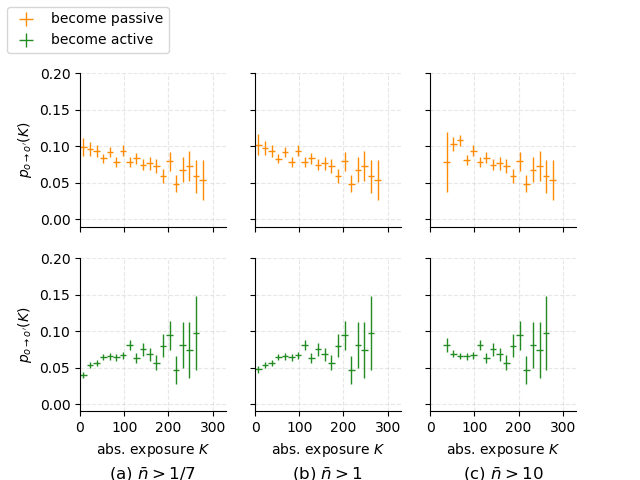

INFO: Calc op-change


/home/lochnerpik@gmail.com/master/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


INFO: Calc op-change
INFO: Calc op-change


In [12]:
# plot drf for different t_x (fig 4.12)

cns_glasses.output_folder = "final/"
suffix = "min_degree"
x_max = 330
fig,ax = plt.subplots(2,3,subplot_kw = {"adjustable":'box', "aspect":x_max/0.2})
index = 0
lables = [r"(a) $\bar n > 1/7$", r"(b) $\bar n > 1$", r"(c) $\bar n > 10$"]
q_binning = False
for min_degree in [1/7, 1, 10]:
    expo_tmp = exposure[exposure.n_nbs_mean > min_degree]
    data, expo_agg = cns_glasses.opinion_change_per_exposure(expo_tmp, opinion_type, opinion_change_time = 1)
    data = data[data.exposure < x_max]
    
    _,_,l1 = cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == True], "expo_nmb", binning, n_bins=15, bin_width=15, \
                save_plots=False, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.2, fig=fig, ax=ax[1][index], \
                label="become active", q_binning = q_binning, loglog=False, step_plot=True, color="forestgreen", \
                suffix=suffix,legend_loc="upper left", legend=False, min_bin_size = 30, x_lim=x_max, xlabel=r"abs. exposure $K$")
    _,_,l2 = cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == False], "expo_nmb", binning, n_bins=15, bin_width=15, \
                save_plots=False, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.2, fig=fig, ax=ax[0][index], \
                label="become passive", loglog=False, q_binning=q_binning, step_plot=True, color="darkorange", \
                suffix=suffix,legend_loc="upper left", legend=False, min_bin_size = 30, x_lim=x_max)
    index += 1

for i in range(2):
    for j in range(3):
        ax[i][j].set_xticks((0,100,200, 300))
    
ax[1][0].set_title(lables[0], y=-0.5)
ax[1][1].set_title(lables[1], y=-0.5)
ax[1][2].set_title(lables[2], y=-0.5)
fig.legend((l2,l1), ("become passive","become active"),"upper left")
fig.subplots_adjust(hspace=0)
#fig.tight_layout()
fig.savefig("tmp/final/degree_comparison_absolute_qbin.pdf" , bbox_inches='tight')